# This notebook is intended to show the finalised model for the algorithm subsystem.

In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import re

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, precision_recall_fscore_support

from imblearn.over_sampling import SMOTE
from collections import Counter

import pickle

# Steps for Algorithm:

1. Converting PDF résumés to .txt format
2. Extract and clean text from .txt résumés into string
3. Extract skills from string
4. Use TF-IDF to vectorize string
5. SVM model predicts applicant’s suitability using vectorized string
6. Packaged model

# Step 1: Convert PDF Resume to TXT

### folder_path will be directory where you store resumes

In [2]:
folder_path = "C:/Users/iamki/Desktop/Capstone/Sample Resume"
files = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
files = [f for f in files if ".txt" not in f]
jd_files = [f for f in files if "Job Description" in f]
resume_files = [f for f in files if f not in jd_files]
resume_files

['Field Support Not Suitable - 1.pdf',
 'Field Support Not Suitable - 2.pdf',
 'Field Support Not Suitable - 3.pdf',
 'Field Support Suitable - 1.pdf',
 'Field Support Suitable - 2.pdf',
 'Field Support Suitable - 3.pdf',
 'Field Support Suitable - 4.pdf',
 'Field Support Suitable - 5.pdf',
 'Field Support Suitable - 6.pdf',
 'GPIS Executive Not Suitable - 1.pdf',
 'GPIS Executive Not Suitable - 10.pdf',
 'GPIS Executive Not Suitable - 11.pdf',
 'GPIS Executive Not Suitable - 12.pdf',
 'GPIS Executive Not Suitable - 13.pdf',
 'GPIS Executive Not Suitable - 14.pdf',
 'GPIS Executive Not Suitable - 15.pdf',
 'GPIS Executive Not Suitable - 16.pdf',
 'GPIS Executive Not Suitable - 17.pdf',
 'GPIS Executive Not Suitable - 18.pdf',
 'GPIS Executive Not Suitable - 19.pdf',
 'GPIS Executive Not Suitable - 2.pdf',
 'GPIS Executive Not Suitable - 20.pdf',
 'GPIS Executive Not Suitable - 21.pdf',
 'GPIS Executive Not Suitable - 22.pdf',
 'GPIS Executive Not Suitable - 23.pdf',
 'GPIS Executive No

In [3]:
# import aspose.words as aw
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

In [4]:
def pdf2Txt(folderPath, resumeFile):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(folderPath + "/" + resumeFile, "rb")
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()
    
    with open(folderPath + "/" + resumeFile + ".txt", "w", encoding = 'utf-8') as f:
        f.write("".join(text))

    fp.close()
    device.close()
    retstr.close()
    return folderPath + "/" + resumeFile + ".txt"

# Step 2: Extract and clean text

### Function to open & read txt file

In [5]:
def read(txtFile):
    f = open(txtFile,encoding = 'ISO-8859-1')
    text = f.readlines()
    return text

### Function to remove stopwords & lemmatize

In [6]:
# STOPWORD REMOVAL
def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    # Get position tags
    word_pos_tags = pos_tag(word_tokenize(string))
    # Map the position tag and lemmatize the word/token
    a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return ' '.join(a)

### Function to remove stopwords, lemmatize, clean txt file and remove regex

In [7]:
pat = '[a-zA-Z]+'

In [8]:
def getText(text):
    i = 0
    newtext = ''
    for EachLine in text:
        newtext += EachLine.lower()
    # newtext = remove_noneng_nonskill(newtext)
    newtext = stopword(newtext)
    newtext = lemmatizer(newtext)
    # newtext = remove_noneng_nonskill(newtext)
    newtext_lst = re.findall(pat, newtext)
    # print(newtext_lst)
    if len(newtext_lst) <= 20:
        return " ".join(newtext_lst[0:len(newtext_lst)])
    else:
        return " ".join(newtext_lst[9:len(newtext_lst)])

### Combining above functions

In [9]:
def extractText(resumePath):
    return getText(read(resumePath))

# Step 3: Extract skills from resumes

In [10]:
skills_csv = pd.read_csv('C:/Users/iamki/ML Prototyping (3)/ML Prototyping/skills_df_cleaned.csv')
skill_list = skills_csv['name'].tolist()
skill_list += [
    "itil", "php", "jquery", "javascript" , "bootstrap", "codeigniter", "visual", "c", "powerbuilder", "html", "css",
    ".net", "net", "crystal report", "xml", "soap", "rest", "boomi", "mssql", "mysql", "mariadb", "oracle", "apache", "iis",
    "ubuntu", "linux", "magento", "api", "office", "asp", "sql", "ajax", "joomla", "tradenet", "as400", "programming",
    "vba", "microsoft", "access", "excel", "suite", "six sigma", "project management", "sap", "word", "powerpoint",
    "power point", "visio", "minitab", "flexsim", "certificate", "certified", "certification", "pmp", "ccna",
    "cisa", "cissp", "crisc", "isms", "qlik", "power bi", "azure", "aspnet", "css", "git", "java", "mariadb", "unix", "oracle",
    "sybase"
                  ]

In [11]:
def getSkills(text):
    skills = []
    for word in skill_list:
        if word in text:
            skills.append(word)
    return list(dict.fromkeys(skills))

# Model Training (not part of algorithm)

## Creating dataframe to train model before packaging

### Function to label resumes

In [12]:
def label(resumePath):
    #Field Support Engineer
    if "Selected" in resumePath and "Field" in resumePath and "Not Suitable" not in resumePath:
        return "Suitable for Field Support Engineer"
    elif "Suitable" in resumePath and "Field" in resumePath and "Not Suitable" not in resumePath:
        return "Suitable for Field Support Engineer"
    elif "Rejected" in resumePath and "Field" in resumePath:
        return "Not Suitable for Field Support Engineer"
    elif "Not Suitable" in resumePath and "Field" in resumePath:
        return "Not Suitable for Field Support Engineer"
    
    #Systems Analyst
    elif "Selected" in resumePath and "System" in resumePath and "Not Suitable" not in resumePath:
        return "Suitable for System Analyst"
    elif "Suitable" in resumePath and "System" in resumePath and "Not Suitable" not in resumePath:
        return "Suitable for System Analyst"
    elif "Rejected" in resumePath and "System" in resumePath:
        return "Not Suitable for System Analyst"
    elif "Not Suitable" in resumePath and "System" in resumePath:
        return "Not Suitable for System Analyst"
    
    #GPIS Executive
    elif "Selected" in resumePath and "GPIS" in resumePath and "Not Suitable" not in resumePath:
        return "Suitable for GPIS Executive"
    elif "Suitable" in resumePath and "GPIS" in resumePath and "Not Suitable" not in resumePath:
        return "Suitable for GPIS Executive"
    elif "Rejected" in resumePath and "GPIS" in resumePath:
        return "Not Suitable for GPIS Executive"
    elif "Not Suitable" in resumePath and "GPIS" in resumePath:
        return "Not Suitable for GPIS Executive"

### Function to get job applied using resume file name

In [13]:
def jobApplied(resumePath):
    if "Field" in resumePath:
        return "Field Support Engineer"
    elif "GPIS" in resumePath:
        return "GPIS Executive"
    else:
        return "System Analyst"

In [14]:
def allResumesTrain(folderPath, resumeFiles):
    output = []
    for resume in resumeFiles:
        # print(resume)
        path = pdf2Txt(folderPath, resume)
        job = jobApplied(resume)
        resume_words = extractText(path)
        skills = getSkills(resume_words)
        data = [resume, job, resume_words, label(path), skills]
        output.append(data)
    return pd.DataFrame(output, columns = ["Resume", "Job Applied", "Text", "Label", "Skills"])

In [15]:
Corpus = allResumesTrain(folder_path, resume_files)
Corpus

,Resume,Job Applied,Text,Label,Skills
0,Field Support Not Suitable - 1.pdf,Field Support Engineer,danfoss singapore pte ltd international busine...,Not Suitable for Field Support Engineer,"[corda, customer service, food preparation, hu..."
1,Field Support Not Suitable - 2.pdf,Field Support Engineer,com singapore citizen availability immediate e...,Not Suitable for Field Support Engineer,"[active directory, asset management, certified..."
2,Field Support Not Suitable - 3.pdf,Field Support Engineer,personal information name address gender age n...,Not Suitable for Field Support Engineer,"[active directory, antivirus software, arity, ..."
3,Field Support Suitable - 1.pdf,Field Support Engineer,lawrencemark gmail com objective utilize vast ...,Suitable for Field Support Engineer,"[active directory, computer engineering, compu..."
4,Field Support Suitable - 2.pdf,Field Support Engineer,personal information name address gender age n...,Suitable for Field Support Engineer,"[administrative support, asset management, bas..."
...,...,...,...,...,...
157,System Analyst Suitable - 2.pdf,System Analyst,singapore aimarasigan hotmail com well experie...,Suitable for System Analyst,"[acceptance testing, barcodes, business proces..."
158,System Analyst Suitable - 3.pdf,System Analyst,passion support application provide customer s...,Suitable for System Analyst,"[apache tomcat, basic a, banking, customer ser..."
159,System Analyst Suitable - 4.pdf,System Analyst,z a orchard road ngee ann city tower singapore...,Suitable for System Analyst,"[biology, business analysis, capacity manageme..."
160,System Analyst Suitable - 5.pdf,System Analyst,princesa palawan sherlockbajenting gmail com o...,Suitable for System Analyst,"[net framework, accounting, application develo..."


In [16]:
X, y = Corpus["Text"], Corpus["Label"]
Encoder = LabelEncoder()
y = Encoder.fit_transform(y)
counter = Counter(y)
for k, v in counter.items():
    per = v/len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

le_name_mapping = dict(zip(Encoder.classes_, Encoder.transform(Encoder.classes_)))
print(le_name_mapping)

Class=0, n=3 (1.852%)
Class=3, n=6 (3.704%)
Class=1, n=83 (51.235%)
Class=4, n=41 (25.309%)
Class=2, n=23 (14.198%)
Class=5, n=6 (3.704%)
{'Not Suitable for Field Support Engineer': 0, 'Not Suitable for GPIS Executive': 1, 'Not Suitable for System Analyst': 2, 'Suitable for Field Support Engineer': 3, 'Suitable for GPIS Executive': 4, 'Suitable for System Analyst': 5}


In [17]:
tfidf = TfidfVectorizer(ngram_range=(1,2))    
X_tfidf = tfidf.fit_transform(X)

In [18]:
oversample = SMOTE(sampling_strategy='not majority', k_neighbors=2, random_state=42)
# oversample = RandomOverSampler(sampling_strategy = 'not majority')
X_tfidf, y = oversample.fit_resample(X_tfidf, y)
print(Counter(y))

Counter({0: 83, 3: 83, 1: 83, 4: 83, 2: 83, 5: 83})


In [19]:
X_train_tfidf, X_test_tfidf, y_train, y_test = model_selection.train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.79      0.96      0.87        24
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        13
           4       0.90      0.60      0.72        15
           5       1.00      1.00      1.00        21

    accuracy                           0.93       100
   macro avg       0.95      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100

SVM Accuracy Score ->  93.0


Precision: 0.935344827586207
Recall: 0.93
F-score: 0.9263018867924528
Support: None


Cross Validation accuracy scores: [0.95       0.9        0.95       0.925      0.95       0.975
 1.         1.         1.         0.92307692]
Cross Validation accuracy: 0.957 +/- 0.034


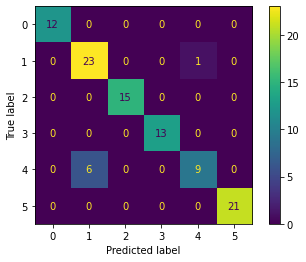

In [20]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='linear', gamma='auto', probability = True)
SVM.fit(X_train_tfidf, y_train)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, predictions_SVM))

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_test)*100)
print("\n")
# Confusion matrix
plot_confusion_matrix(SVM, X_test_tfidf, y_test)

precision, recall, f1score, support = precision_recall_fscore_support(y_test, predictions_SVM, average='weighted')
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F-score: {}'.format(f1score))
print('Support: {}'.format(support))
print("\n")

scores = model_selection.cross_val_score(SVM, X_train_tfidf, y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

# Function to create dataframe of new resumes to parse into trained model

### folder_path will be directory where you store resumes

In [21]:
# Function to extract text and relevant information from all resume files
folder_path = "C:/Users/iamki/Desktop/Capstone/Sample Resume"
def allResumes(folderPath, resumeFiles):
    output = []
    for resume in resumeFiles:
        path = pdf2Txt(folderPath, resume)
        job = jobApplied(resume)
        resume_words = extractText(path)
        skills = getSkills(resume_words)
        data = [resume, job, resume_words, skills]
        output.append(data)
        df = pd.DataFrame(output, columns = ["Resume", "Job Applied", "Text", "Skills"])
    return df

# Step 4: Vectorize text using TF-IDF

In [22]:
def vectorize_dfText(df):
    return tfidf.transform(df["Text"])

# Step 5: Use SVM model to make predictions

In [23]:
def predSuit(tfidf_SVM):
    predictions = SVM.predict_proba(tfidf_SVM)
    return np.round(predictions, decimals=5)*100

In [24]:
le_name_mapping = dict(zip(Encoder.classes_, Encoder.transform(Encoder.classes_)))
print(le_name_mapping)

{'Not Suitable for Field Support Engineer': 0, 'Not Suitable for GPIS Executive': 1, 'Not Suitable for System Analyst': 2, 'Suitable for Field Support Engineer': 3, 'Suitable for GPIS Executive': 4, 'Suitable for System Analyst': 5}


# Step 6: Package model

## Combine all the functions

In [25]:
def model(folderPath, resumeFiles):
    resumes_df = allResumes(folderPath, resumeFiles)
    vectors = vectorize_dfText(resumes_df)
    predictions = predSuit(vectors)
    #print(predictions)
    predictions_df = pd.DataFrame(predictions, columns = ["Not Suitable for Field Support Engineer",
                             "Not Suitable for GPIS Executive",
                             "Not Suitable for System Analyst",
                             "Suitable for Field Support Engineer",
                             "Suitable for GPIS Executive",
                             "Suitable for System Analyst"
                            ])
    df_final = pd.concat([resumes_df, predictions_df], axis=1)
    return df_final

In [26]:
model_pickle = pickle.dump(model, open('finalisedModel.pkl', 'wb'))
# model_pickle = pickle.dump(model, open('finalisedModel_classBalanced.sav', 'wb'))

In [27]:
# Loading text extraction + vectorizing object + model
load_model = pickle.load(open('finalisedModel.pkl', 'rb'))
# load_model = pickle.load(open('finalisedModel_classBalanced.sav', 'rb'))

In [28]:
# load_model(folder_path, resume_files)